In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from bayes_traj.pyro_helper import *

torch.set_default_dtype(torch.double)

# Read toy data and plot

In [6]:
df = pd.read_csv('2d_gaussian_3_visits_std-0.5.csv')
preds = ['intercept', 'age']
targets = ['y1']

Color-code data based on ground-truth trajectory assignment ('traj_gt')

Text(0, 0.5, 'y1')

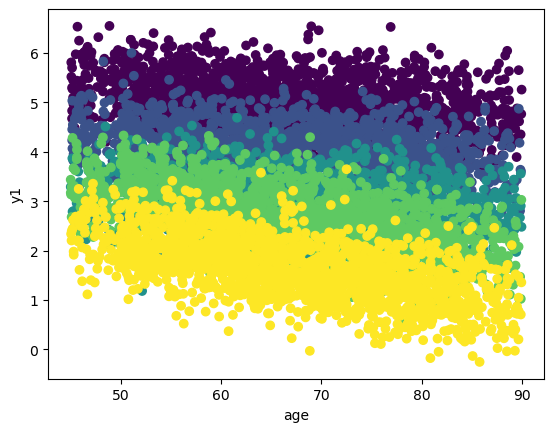

In [3]:
plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
plt.xlabel('age')
plt.ylabel('y1')

# Fit to data

In [3]:
!bayes_traj_main --in_csv 2d_gaussian_3_visits_std-0.5.csv --targets y1 --groupby id --prior 2d_gaussians_3_visits_std-0.5_prior.p --verbose --iters 4000 --repeats 1 --use_pyro -k 5 --out_model foo2_pyro.pt

Reading prior...
Reading data...
Fitting...
step    0 loss = 2.629
step  100 loss = 1.865
step  200 loss = 1.866
step  300 loss = 1.435
step  400 loss = 1.405
step  500 loss = 1.283
step  600 loss = 1.295
step  700 loss = 1.283
step  800 loss = 1.257
step  900 loss = 1.376
step 1000 loss = 1.449
step 1100 loss = 1.275
step 1200 loss = 1.222
step 1300 loss = 1.253
step 1400 loss = 1.225
step 1500 loss = 1.279
step 1600 loss = 1.200
step 1700 loss = 1.198
step 1800 loss = 1.217
step 1900 loss = 1.218
step 2000 loss = 1.200
step 2100 loss = 1.172
step 2200 loss = 1.176
step 2300 loss = 1.200
step 2400 loss = 1.182
step 2500 loss = 1.187
step 2600 loss = 1.178
step 2700 loss = 1.183
step 2800 loss = 1.182
step 2900 loss = 1.196
step 3000 loss = 1.169
step 3100 loss = 1.166
step 3200 loss = 1.166
step 3300 loss = 1.177
step 3400 loss = 1.173
step 3500 loss = 1.161
step 3600 loss = 1.165
step 3700 loss = 1.166
step 3800 loss = 1.173
step 3900 loss = 1.158
DONE.


# Inspect fit

In [4]:
model = torch.load('foo2_pyro.pt')

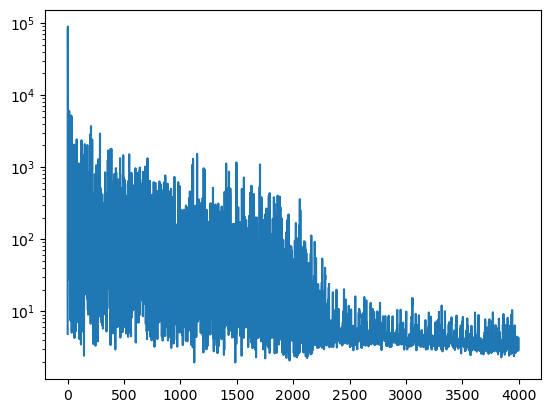

In [18]:
plt.plot(model.losses)
plt.yscale('log')

In [8]:

X_re, X_mask, Y_re, Y_mask, _, _ = get_restructured_data(df, preds, targets, 'id')
print(X_re.shape)
print(Y_re.shape)
print(Y_mask.shape)

torch.Size([3, 3000, 2])
torch.Size([3, 3000, 1])
torch.Size([3, 3000])


In [23]:
print(model.M)
print(model.T)

3
3


In [9]:
probs = model.classify(X_re, Y_real=Y_re, Y_real_mask=Y_mask)


In [74]:
print(probs)

tensor([[0.1600, 0.3000, 0.1900, 0.1900, 0.1600],
        [0.1800, 0.1900, 0.1500, 0.3000, 0.1800],
        [0.2000, 0.1700, 0.2300, 0.1700, 0.2300],
        ...,
        [0.2800, 0.1600, 0.1200, 0.2500, 0.1900],
        [0.2300, 0.1900, 0.1800, 0.2400, 0.1600],
        [0.2100, 0.1200, 0.2300, 0.2600, 0.1800]])


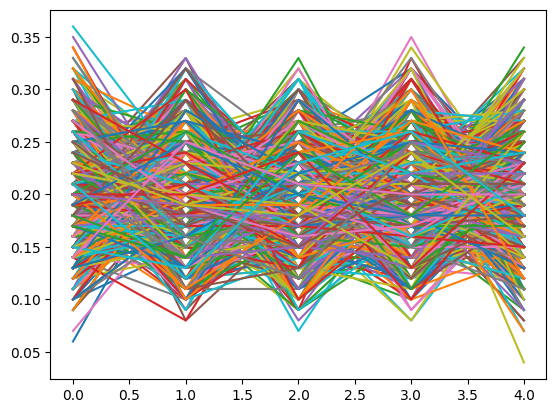

In [75]:
plt.plot(probs.T);

Overlap trajectories with data to inspect fit:

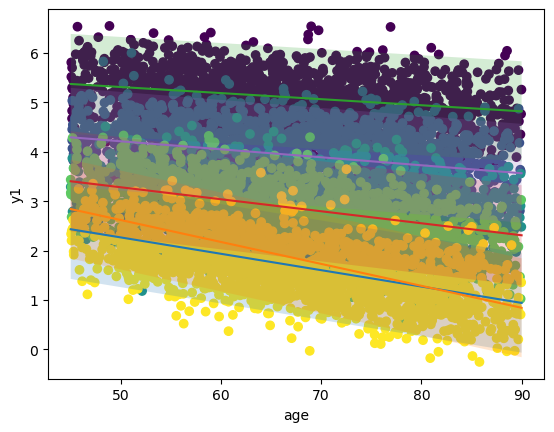

In [10]:
plt.close('all')

plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
plt.xlabel('age')
plt.ylabel('y1')

K = 5
X = torch.ones([100, 2])
X[:, 1] = torch.linspace(45, 90, 100)
for kk in range(K):
    #w = model.params['params']['AutoNormal.locs.W_'][kk, 0].data.numpy()
    #lambda_ = model.params['params']['AutoNormal.locs.lambda_'][kk].data
    #stddev = lambda_.rsqrt().numpy()
    
    stddev = (model.estimate_params()['lambda_mu']).rsqrt().numpy()[kk]
    w = (model.estimate_params()['W_mu']).numpy()[kk,0]
    
    y1_tmp = np.dot(X.numpy(), w.T)
    plt.plot(X[:, 1], y1_tmp)
    lb = y1_tmp - 2*stddev
    ub = y1_tmp + 2*stddev
    plt.fill_between(X[:, 1], lb, ub, alpha=0.2)
plt.show()

In [ ]:
q